In [1]:
import numpy as np
import matplotlib.pyplot as plt
from diffractio import um, mm
import cupy as cp


from diffractio.scalar_sources_X import Scalar_source_X
from diffractio.scalar_masks_X import Scalar_mask_X
from diffractio.scalar_sources_XY import Scalar_source_XY
from diffractio.scalar_masks_XY import Scalar_mask_XY

%matplotlib ipympl

Main monte carlo diffraction function for GPU.

In [2]:
def setup_coordinates_slit(det_width_x, det_width_y, num_px_det_x, num_px_det_y, det_px_width_x, det_px_width_y,
                      samp_width_x, samp_width_y, num_px_samp_x, num_px_samp_y, samp_px_width_x, samp_px_width_y):
    
    num_pixels_det = int(num_px_det_x * num_px_det_y)
    num_pixels_samp = int(num_px_samp_x * num_px_samp_y)
    det_yx_indices = np.indices((num_px_det_y, num_px_det_x)).reshape(2, num_pixels_det).T

    det_yx_coords = np.zeros(det_yx_indices.shape, dtype = np.float64)
    det_yx_coords[:, 0] = det_yx_indices[:, 0] * det_px_width_y - det_width_y / 2  + det_px_width_y / 2
    det_yx_coords[:, 1] = det_yx_indices[:, 1] * det_px_width_x - det_width_x / 2  + det_px_width_x / 2 

    samp_yx_indices = np.indices((num_px_samp_y, num_px_samp_x)).reshape(2, num_pixels_samp).T
    samp_yx_coords = np.zeros(samp_yx_indices.shape, dtype = np.float64)

    samp_yx_coords[:, 0] = samp_yx_indices[:, 0] * samp_px_width_y - samp_width_y / 2  + samp_px_width_y / 2
    samp_yx_coords[:, 1] = samp_yx_indices[:, 1] * samp_px_width_x - samp_width_x / 2  + samp_px_width_x / 2 

    det_yx_coords = det_yx_coords.T.reshape(2, num_px_det_y, num_px_det_x)
    samp_yx_coords = samp_yx_coords.T.reshape(2, num_px_samp_y, num_px_samp_x)
    
    return det_yx_coords, samp_yx_coords

def setup_coordinates_circle(det_width_x, det_width_y, num_px_det_x, num_px_det_y, det_px_width_x, det_px_width_y,
                      samp_width_x, samp_width_y, num_px_samp_x, num_px_samp_y, samp_px_width_x, samp_px_width_y
                      aperture_radius):
    
    num_pixels_det = int(num_px_det_x * num_px_det_y)
    num_pixels_samp = int(num_px_samp_x * num_px_samp_y)
    det_yx_indices = np.indices((num_px_det_y, num_px_det_x)).reshape(2, num_pixels_det).T

    det_yx_coords = np.zeros(det_yx_indices.shape, dtype = np.float64)
    det_yx_coords[:, 0] = det_yx_indices[:, 0] * det_px_width_y - det_width_y / 2  + det_px_width_y / 2
    det_yx_coords[:, 1] = det_yx_indices[:, 1] * det_px_width_x - det_width_x / 2  + det_px_width_x / 2 

    samp_yx_indices = det_yx_indices[np.sqrt(det_yx_coords[:, 1] ** 2 + det_yx_coords[:, 0] ** 2) < aperture_radius]
    samp_yx_coords = det_yx_coords[np.sqrt(det_yx_coords[:, 1] ** 2 + det_yx_coords[:, 0] ** 2) < aperture_radius]
    
    det_yx_coords = det_yx_coords.T.reshape(2, num_px_det_y, num_px_det_x)
    samp_yx_coords = samp_yx_coords.T.reshape(2, num_px_samp_y, num_px_samp_x)
    
    return det_yx_coords, samp_yx_coords

def diffractio_rs_aperture_1D(x0, 
                           z_prop,
                           aperture_width, 
                           wavelength,
                           draw_inputs=False):

    # Make scalar source
    u0 = Scalar_source_X(x0, wavelength)
    u0.plane_wave(z0=0, A = 1.0)

    # Make scalar diffraction mask
    t0 = Scalar_mask_X(x0, wavelength)
    t0.slit(x0=0, size=aperture_width*um)

    u1=t0*u0
    z = z_prop
    u2 = u1.RS(z=z, new_field=True)

    if draw_inputs:
        u0.draw()
        t0.draw()

    return u2

def diffractio_rs_aperture_2D(x0, 
                              y0,
                              z_prop,
                              aperture_width, 
                              wavelength,
                              draw_inputs=False):

    # Make scalar source
    u0 = Scalar_source_XY(x0, y0, wavelength)
    u0.plane_wave(z0=0)

    # Make scalar diffraction mask
    t0=Scalar_mask_XY(x0, y0, wavelength)
    t0.circle(r0=(0 * um, 0 * um), radius=(aperture_width * um, aperture_width * um))
    
    u1=t0*u0
    z = z_prop
    u2 = u1.RS(z=z, new_field=True)

    if draw_inputs:
        u0.draw(kind='intensity')
        t0.draw(kind='intensity')

    return u2

def U(z, U_0, a, k):
    # Ensure the input is converted to a complex type to handle complex arithmetic
    z = np.complex(z)
    a = np.complex(a)
    k = np.complex(k)
    
    # The complex number j in Python is represented by 1j
    j = 1j
    
    # Defining the complex exponential terms
    term1 = np.exp(j * k * z) / z
    term2 = np.exp(j * k * np.sqrt(z**2 + a**2)) / np.sqrt(z**2 + a**2)
    
    # Calculating U(z)
    U_z = U_0 * (term1 - term2)
    
    return U_z

In [3]:
mempool = cp.get_default_memory_pool()

with cp.cuda.Device(0):
    mempool.set_limit(size=4*1024**3)

def monte_carlo_diffraction_cupy(num_rays, 
                                 final_image_real,
                                 final_image_imag,
                                 pixel_size,
                                 source_yx,
                                 det_yx,
                                 z_prop,
                                 wavelength,
                                 batch_size=int(1e7)):  # Batch size of rays to GPU
    
    # Get number of samples in source and detector
    y_sam = source_yx.shape[1]
    x_sam = source_yx.shape[2]
    y_det = det_yx.shape[1]
    x_det = det_yx.shape[2]
    
    for start_idx in range(0, num_rays, batch_size):
        end_idx = min(start_idx + batch_size, num_rays)
        current_batch_size = end_idx - start_idx

        # Get random pixel samples of the source (or aperture) and the detector
        rand_source_idx_x = cp.random.randint(x_sam, size=current_batch_size)
        rand_source_idx_y = cp.random.randint(y_sam, size=current_batch_size)
        rand_det_idx_x = cp.random.randint(x_det, size=current_batch_size)
        rand_det_idx_y = cp.random.randint(y_det, size=current_batch_size)
        
        # Get the x, y, z coordinates of the source plane
        source_x = source_yx[:, rand_source_idx_y, rand_source_idx_x][1, :]
        source_y = source_yx[:, rand_source_idx_y, rand_source_idx_x][0, :]
        source_z = cp.zeros(current_batch_size)
        
        # Get the x, y, z coordinates of the detector plane
        det_x = det_yx[:, rand_det_idx_y, rand_det_idx_x][1, :]
        det_y = det_yx[:, rand_det_idx_y, rand_det_idx_x][0, :]
        det_z = cp.ones(current_batch_size) * z_prop
        
        # Convert coordinates to a vector for convenience
        ray_source_coord = cp.array([source_z, source_y, source_x])   
        ray_det_coord = cp.array([det_z, det_y, det_x])
        
        # Create ray vector and get magnitude and direction
        ray = ray_det_coord - ray_source_coord
        ray_magnitude = cp.linalg.norm(ray, axis = 0)
        ray_direction = ray / ray_magnitude
        
        # Get the local normal of the source pixel plane, which will also point in the same direction
        # as the detector pixel plane
        source_v = cp.array([1, 0, 0])
        det_v = cp.array([1, 0, 0])
    
        distance = cp.sqrt((source_y - det_y) ** 2 + 
                           (source_x - det_x) ** 2 + 
                           z_prop ** 2)
        
        N = num_rays # Rename number of rays variable so it follows math more closely
        dN0 = N / ((y_sam * x_sam)) # Number of rays per pixel in point source plane (We only have 1 pixel at source in this test)
        dN1 = N / ((y_det * x_det)) # Number of rays per pixel in detector plane
        
        dS0 = pixel_size * (y_sam * x_sam) # Pixel size at source plane - we have one pixel so the area of the source, or tube of rays is just this pixel
        
        # Apparent area at detector plane - I am not sure exactly why this is correct, or if it is correct, but it gives the right answer
        # for a point source - this link seems to support what I have worked out
        # - https://raytracing.github.io/books/RayTracingTheRestOfYourLife.html#samplinglightsdirectly/gettingthepdfofalight
        # but, the answer I have for dS1 is essentially just the factors that are required to recreate the 
        # rayleigh sommerfeld diffraction integral - it seems a little unneccessary to describe that equation in this way,
        # and perhaps I am missing something. At least does have the cosine term that is expected in the form of 
        # the dot product between the ray and detector vector.
        dS1 = (pixel_size * y_det * x_det) * (cp.dot(ray_direction.T, det_v)) / (distance ** 2)
        
        # See Chapter 2 of Marco Mout thesis - 2.97 onwards
        ws = cp.sqrt((N * dS0) / dN0) * cp.dot(ray_direction.T, source_v) # This extra dot product shows up in the papers description of this method. 
        wp = cp.sqrt((N * dS1) / dN1)
        wi = cp.sqrt(1 / cp.dot(ray_direction.T, det_v))

        # Calculate phase and amplitude factors
        phase = cp.exp(1j * distance * ((2 * cp.pi) / wavelength))
        amplitude = wi * ws * wp
        complex_rays = amplitude * phase

        # Add complex wavefront to each pixel in the image
        cp.add.at(final_image_real, (rand_det_idx_y, rand_det_idx_x), complex_rays.real)
        cp.add.at(final_image_imag, (rand_det_idx_y, rand_det_idx_x), complex_rays.imag)

    final_image = final_image_real + 1j * final_image_imag
    
    # Include final factors which scale image by pixel size, and have an extra term from the rayleigh sommerfeld integral. 
    return final_image * (1 / (num_rays * pixel_size)) * (-1j * 1 / (wavelength)) * np.exp(1j * (2 * np.pi / wavelength) * z_prop * np.pi)

Set up coordinates of detector and sample plane, and other variables such as propagation distance and wavelength

In [4]:
z_prop = 1 * mm
wavelength = 0.638 * um

det_width_x = 10000 * um
samp_width_x = 1 * um
det_width_y = 0 * um
samp_width_y = 0 * um

num_px_det_x = 100
num_px_det_y  = 1
num_px_samp_x = 1
num_px_samp_y = 1

det_px_width_x = det_width_x / num_px_det_x 
det_px_width_y = det_width_y / num_px_det_y

samp_px_width_x = samp_width_x / num_px_samp_x 
samp_px_width_y = samp_width_y / num_px_samp_y

det_yx_coords, samp_yx_coords = setup_coordinates_slit(det_width_x, det_width_y, num_px_det_x, num_px_det_y, det_px_width_x, det_px_width_y,
                                                  samp_width_x, samp_width_y, num_px_samp_x, num_px_samp_y, samp_px_width_x, samp_px_width_y)
print(samp_yx_coords)

[[[0.]]

 [[0.]]]


Run this cell if you have a GPU

In [5]:
num_rays=int(1e8)

# Assuming sample_yx_coords and det_yx_coords are defined elsewhere and are numpy arrays, convert them:
sample_yx_coords = cp.asarray(samp_yx_coords)
det_yx_coords = cp.asarray(det_yx_coords)

# Initialize final image and aperture phase shifts arrays on GPU
final_image_real = cp.zeros([num_px_det_y, num_px_det_x], dtype=cp.float64)
final_image_imag = cp.zeros([num_px_det_y, num_px_det_x], dtype=cp.float64)

final_image = monte_carlo_diffraction_cupy(num_rays, 
                                           final_image_real, 
                                           final_image_imag, 
                                           det_px_width_x * det_px_width_x,
                                           sample_yx_coords,
                                           det_yx_coords,
                                           z_prop,
                                           wavelength)

det_yx_coords = cp.asnumpy(det_yx_coords)
final_image = cp.asnumpy(final_image)

Analytic solution for intensity of a point source using Rayleigh Sommerfeld Theory

In [6]:
r = np.sqrt(det_yx_coords[1, 0, :]**2 + z_prop**2)
k = (2 * np.pi) / wavelength
analytic_point_source = 1.0 * np.exp(1j * k * r) / (r) * ((z_prop) / r) * (-1j * 1 / (wavelength))



Plotting of amplitude of point source.

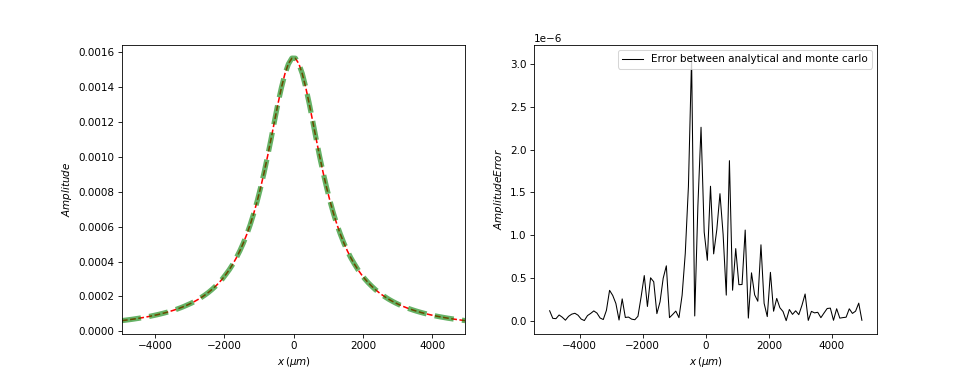

In [7]:

fig, ax = plt.subplots(figsize = (13, 5), nrows = 1, ncols = 2)

ax[0].set_xlabel('$x\,(\mu m)$')
ax[0].set_ylabel('$Amplitude$')
ax[0].set_xlim(left=det_yx_coords[1, 0, 0], right=det_yx_coords[1, 0, -1])
ax[0].plot(det_yx_coords[1, 0, :], np.abs(analytic_point_source), '--r', label='Spherical Wave Analytic')
ax[0].plot(det_yx_coords[1, 0, :], np.abs(final_image[0, :]), '--g', label='Spherical Wave Monte Carlo', linewidth = 5, alpha = 0.6)
ax[1].set_xlabel('$x\,(\mu m)$')
ax[1].set_ylabel('$Amplitude Error$')
ax[1].plot(det_yx_coords[1, 0, :], np.abs(np.abs(final_image[0, :]) - np.abs(analytic_point_source)), 'k', label='Error between analytical and monte carlo', linewidth = 1, alpha = 1)
plt.legend()

mempool.free_all_blocks()


How to calculate if we have two point sources? 

In [8]:
z_prop = 1000 * um
wavelength = 0.638 * um

det_width_x = 500 * um
samp_width_x = 50 * um
det_width_y = 0 * um
samp_width_y = 0 * um

num_px_det_x = 1000
num_px_det_y  = 1
num_px_samp_x = 100
num_px_samp_y = 1

det_px_width_x = det_width_x / num_px_det_x 
det_px_width_y = det_width_y / num_px_det_y

samp_px_width_x = samp_width_x / num_px_samp_x 
samp_px_width_y = samp_width_y / num_px_samp_y

det_yx_coords, samp_yx_coords = setup_coordinates_slit(det_width_x, det_width_y, num_px_det_x, num_px_det_y, det_px_width_x, det_px_width_y,
                                                  samp_width_x, samp_width_y, num_px_samp_x, num_px_samp_y, samp_px_width_x, samp_px_width_y)
print(samp_yx_coords)

[[[  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.  ]]

 [[-24.75 -24.25 -23.75 -23.25 -22.75 -22.25 -21.75 -21.25 -20.75 -20.25
   -19.75 -19.25 -18.75 -18.25 -17.75 -17.25 -16.75 -16.25 -15.75 -15.25
   -14.75 -14.25 -13.75 -13.25 -12.75 -12.25 -11.75 -11.25 -10.75 -10.25
    -9.75  -9.25  -8.75  -8.25  -7.75  -7.25  -6.75  -6.25  -5.75 

In [9]:
r = np.sqrt((samp_yx_coords[1, 0, :, np.newaxis] - det_yx_coords[1, 0, :])**2 + z_prop**2)
k = (2 * np.pi) / wavelength

analytic_point_source = 1.0 * np.exp(1j * k * r) / (r) * ((z_prop) / r) * (-1j * 1 / (wavelength)) * np.exp(1j * k * z_prop * np.pi)
analytic_point_source = np.sum(analytic_point_source, axis = 0)


In [10]:
num_rays=int(1e9)

sample_yx_coords = cp.asarray(samp_yx_coords)
det_yx_coords = cp.asarray(det_yx_coords)

# Initialize final image and aperture phase shifts arrays on GPU
final_image_real = cp.zeros([num_px_det_y, num_px_det_x], dtype=cp.float64)
final_image_imag = cp.zeros([num_px_det_y, num_px_det_x], dtype=cp.float64)

final_image = monte_carlo_diffraction_cupy(num_rays, 
                                           final_image_real, 
                                           final_image_imag, 
                                           det_px_width_x * det_px_width_x,
                                           sample_yx_coords,
                                           det_yx_coords,
                                           z_prop,
                                           wavelength)

det_yx_coords = cp.asnumpy(det_yx_coords)
final_image = cp.asnumpy(final_image)

In [11]:
u2 = diffractio_rs_aperture_1D(x0=det_yx_coords[1, 0, :], 
                                z_prop=z_prop, 
                                wavelength=wavelength,
                                aperture_width=samp_width_x, 
                                draw_inputs=False)

Good result: factor 2.62


[0.07870638 0.07054147 0.08529573 0.06590685 0.07010725 0.07366973
 0.07749191 0.07270567 0.08379571 0.07621792 0.07699531 0.07466192
 0.07798505 0.07868581 0.07984929 0.07909673 0.07943222 0.07590259
 0.07887151 0.08063195 0.07793468 0.07636416 0.07321916 0.07671803
 0.06764397 0.07247292 0.08121031 0.08969397 0.08508838 0.08474701
 0.09341403 0.07585193 0.08287866 0.0823816  0.0774139  0.07968266
 0.08126329 0.08093479 0.07810741 0.07775323 0.07785786 0.07964956
 0.082257   0.08177464 0.07562549 0.07287105 0.08099927 0.0787881
 0.07722159 0.08491059 0.07489511 0.08007759 0.08681679 0.06774627
 0.08446452 0.06517957 0.07143687 0.10364336 0.07081268 0.07171216
 0.08189279 0.08010546 0.07393203 0.07612065 0.07685862 0.0805052
 0.07890775 0.07825443 0.08046086 0.07826063 0.08129571 0.07689402
 0.07589198 0.07747041 0.07565345 0.07358626 0.08390152 0.07330852
 0.079653   0.0771648  0.08164913 0.07910582 0.11535595 0.11665662
 0.08368991 0.09417879 0.08112552 0.07936326 0.0765182  0.078003

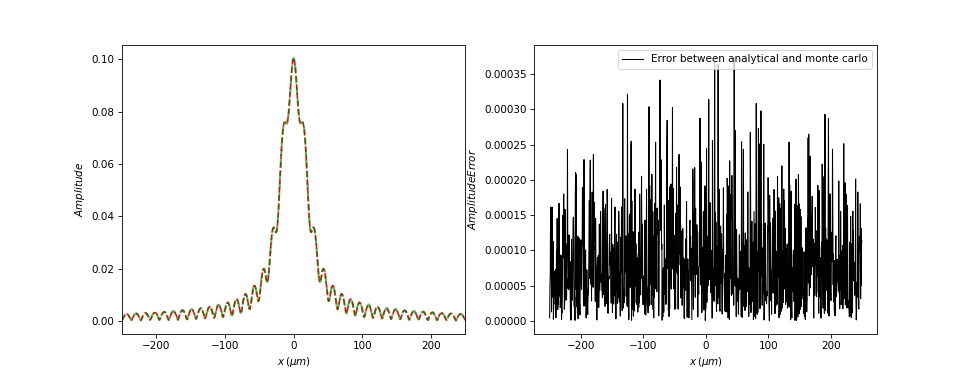

In [12]:

fig, ax = plt.subplots(figsize = (13, 5), nrows = 1, ncols = 2)

ax[0].set_xlabel('$x\,(\mu m)$')
ax[0].set_ylabel('$Amplitude$')
ax[0].set_xlim(left=det_yx_coords[1, 0, 0], right=det_yx_coords[1, 0, -1])
ax[0].plot(det_yx_coords[1, 0, :], np.abs(analytic_point_source), '--r', label='Spherical Wave Analytic')
ax[0].plot(det_yx_coords[1, 0, :], np.abs(final_image[0, :]), '--g', label='Spherical Wave Monte Carlo', linewidth = 2, alpha = 0.6)
# ax[0].plot(det_yx_coords[1, 0, :], np.abs(u2.u), '-k', label='Diffraction RayLeigh Sommerfeld')

print(np.abs(final_image[0, :]) / np.abs(u2.u))
ax[1].set_xlabel('$x\,(\mu m)$')
ax[1].set_ylabel('$Amplitude Error$')
ax[1].plot(det_yx_coords[1, 0, :], np.abs(np.abs(final_image[0, :]) - np.abs(analytic_point_source)), 'k', label='Error between analytical and monte carlo', linewidth = 1, alpha = 1)
plt.legend()

mempool.free_all_blocks()


In [13]:
z_prop = 1000 * um
wavelength = 0.638 * um

det_width_x = 502 * um
samp_width_x = 50 * um
det_width_y = 502 * um
samp_width_y = 50 * um

num_px_det_x = 1001
num_px_det_y  = 1001
num_px_samp_x = 1001
num_px_samp_y = 1001

det_px_width_x = det_width_x / num_px_det_x 
det_px_width_y = det_width_y / num_px_det_y

samp_px_width_x = samp_width_x / num_px_samp_x 
samp_px_width_y = samp_width_y / num_px_samp_y

det_yx_coords, samp_yx_coords = setup_coordinates_slit(det_width_x, det_width_y, num_px_det_x, num_px_det_y, det_px_width_x, det_px_width_y,
                                                  samp_width_x, samp_width_y, num_px_samp_x, num_px_samp_y, samp_px_width_x, samp_px_width_y)

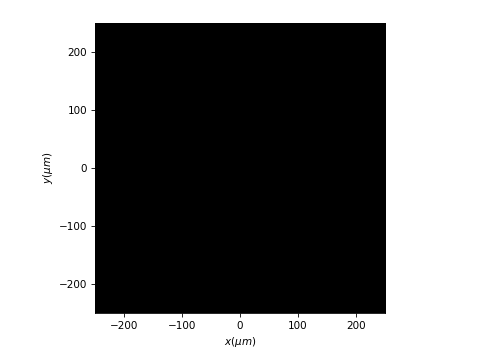

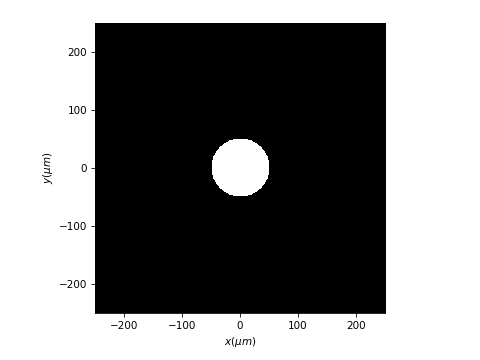

In [14]:
u2 = diffractio_rs_aperture_2D(x0=det_yx_coords[1, 0, :], 
                               y0=det_yx_coords[0, :, 0],
                               z_prop=z_prop, 
                               aperture_width=samp_width_x, 
                               wavelength=wavelength, 
                               draw_inputs=True)

0.2697106868542492
0.26281405773765243


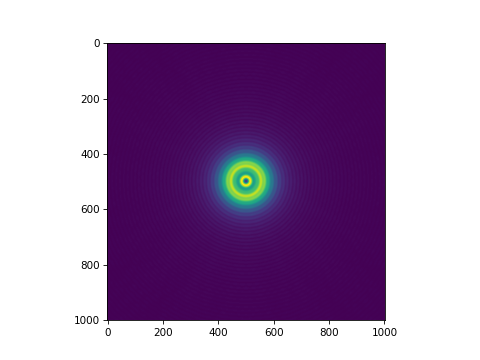

In [15]:
fig, ax = plt.subplots()
ax.imshow(np.abs(u2.u), label='Diffraction Monte Carlo')

print(np.abs(u2.u)[501, 501])
a = samp_width_x 
I = (1**2) * (1 + (z_prop**2)/(z_prop**2 + a**2) - 2 * (z_prop)/np.sqrt(z_prop**2 + a**2) * np.cos(k * z_prop * (np.sqrt(1 + (a/z_prop)**2) - 1)))
print(np.sqrt(I))


In [16]:
num_rays=int(1e9)

# Assuming sample_yx_coords and det_yx_coords are defined elsewhere and are numpy arrays, convert them:
sample_yx_coords = cp.asarray(samp_yx_coords)
det_yx_coords = cp.asarray(det_yx_coords)

# Initialize final image and aperture phase shifts arrays on GPU
final_image_real = cp.zeros([num_px_det_y, num_px_det_x], dtype=cp.float64)
final_image_imag = cp.zeros([num_px_det_y, num_px_det_x], dtype=cp.float64)

final_image = monte_carlo_diffraction_cupy(num_rays, 
                                           final_image_real, 
                                           final_image_imag, 
                                           det_px_width_x * det_px_width_y,
                                           sample_yx_coords,
                                           det_yx_coords,
                                           z_prop,
                                           wavelength)

det_yx_coords = cp.asnumpy(det_yx_coords)
final_image = cp.asnumpy(final_image)

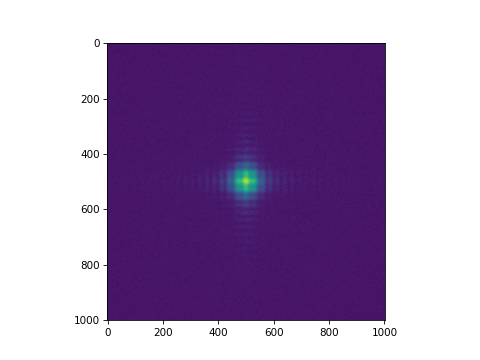

In [17]:
fig, ax = plt.subplots()
ax.imshow(np.abs(final_image), label='Diffraction Monte Carlo')
